Table of Contents
-----------------
- Step 1: Data Merging
- Step 2: Exploratory Data Analysis
- Step 3: Propensity Score Estimation
- Step 4: Covariate Balance Check
- Step 5: Subgroup Analysis for Treatment Effect Heterogeneity 

### Step 1: Data Merging

- What is this code about: Merging multiple CSV files containing practice-level data and aggreagted patient level data into a single DataFrame for Track -2 analysis.
- Why is this important in our overall analysis: It consolidates all data into one structure, ensuring all information is accessible and can be processed together.
- What is the expected result: A single DataFrame combining all practice-level data for subsequent analysis.

In [5]:
import pandas as pd
import os

# Paths to the folders containing the CSV files
practice_folder = 'practice'  
practice_year_folder = 'practice_year'

# Function to merge files into a DataFrame
def merge_files_to_df():
    merged_dfs = []
    for i in range(1, 3401):
        practice_file = f'{practice_folder}/acic_practice_{i:04d}.csv'
        practice_year_file = f'{practice_year_folder}/acic_practice_year_{i:04d}.csv'
        df_practice = pd.read_csv(practice_file)
        df_practice_year = pd.read_csv(practice_year_file)
        df_merged = pd.merge(df_practice, df_practice_year, on='id.practice')
        merged_dfs.append(df_merged)
    return pd.concat(merged_dfs, ignore_index=True)

# Merge files into a single DataFrame
merged_data = merge_files_to_df()
print("Merging completed.")


Merging completed.


In [6]:
merged_data.to_csv("merged_data.csv")

### Step 2: Exploratory Data Analysis (EDA)

- What is this code about: Checking for skewness, null values, and treating outliers in the dataset. Additionally, plotting histograms for covariates before adjustment.
- Why is this important in our overall analysis: EDA helps identify and address data quality issues, ensuring the dataset is clean and suitable for modeling.
- What is the expected result: A cleaner dataset with outliers treated and visual insights into the distribution of covariates.

/var/folders/fq/v58vq1pn5yd36j9frv62v7480000gn/T/ipykernel_25164/3415261407.py:8: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = merged_data.skew()


Skewness:
 id.practice    0.000000
X1            -0.014998
X3            -0.174769
X5             0.058265
X6             0.667699
X7             0.722385
X8             0.246944
X9            -0.004676
year           0.000000
Y              0.410520
Z              0.407823
post           0.000000
n.patients     2.490422
V1_avg         0.634098
V2_avg         0.058262
V3_avg        -0.414934
V4_avg        -0.818141
V5_A_avg      -0.408429
V5_B_avg       0.636330
V5_C_avg       1.037076
dtype: float64
Null values:
 id.practice    0
X1             0
X2             0
X3             0
X4             0
X5             0
X6             0
X7             0
X8             0
X9             0
year           0
Y              0
Z              0
post           0
n.patients     0
V1_avg         0
V2_avg         0
V3_avg         0
V4_avg         0
V5_A_avg       0
V5_B_avg       0
V5_C_avg       0
dtype: int64


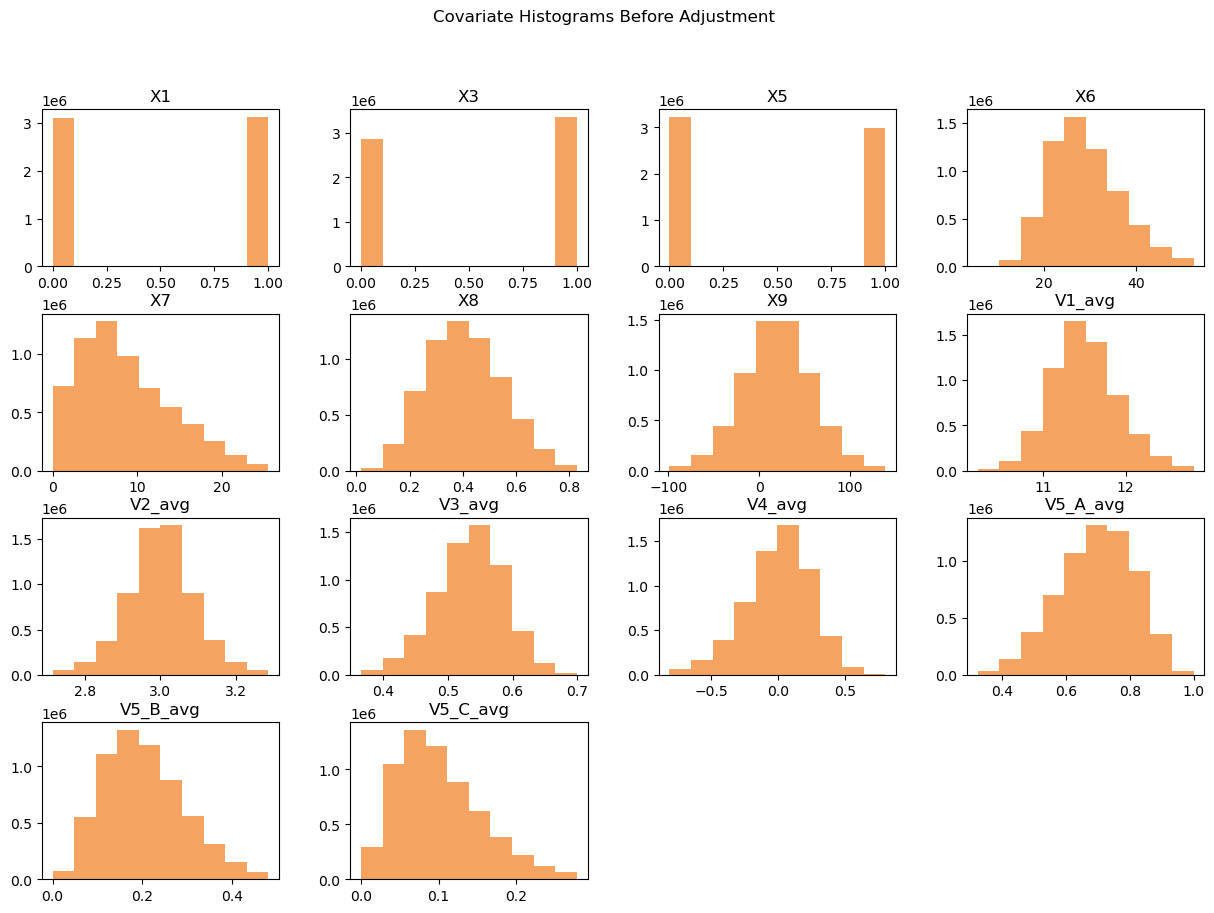

In [7]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# EDA Analysis
## Check for skewness
skewness = merged_data.skew()
print("Skewness:\n", skewness)

## Check for null values
null_values = merged_data.isnull().sum()
print("Null values:\n", null_values)

## Treat outliers using z-score method
z_scores = np.abs(stats.zscore(merged_data.select_dtypes(include=[np.number])))
merged_data = merged_data[(z_scores < 3).all(axis=1)]

# Plot histograms for covariates before adjustment
covariates = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
              'V1_avg', 'V2_avg', 'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg']

axes = merged_data[covariates].hist(figsize=(15, 10), color='sandybrown')

# Remove gridlines from each subplot
for ax in axes.flatten():
    ax.grid(False)  # Turn off gridlines
    
plt.suptitle('Covariate Histograms Before Adjustment')
plt.show()


#### Remarks


### Step 3: Propensity Score Estimation

- What is this code about: Estimating propensity scores using logistic regression and calculating inverse probability weights (IPW).
- Why is this important in our overall analysis: Propensity scores help control for confounding variables, ensuring the treatment and control groups are comparable.
- What is the expected result: Propensity scores and IPW values added to the DataFrame, helping to balance the treatment and control groups.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Propensity Score Estimation
treatment = 'Z'

# One-hot encode categorical variables
categorical_vars = ['X1', 'X2', 'X3', 'X4', 'X5']
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_vars = encoder.fit_transform(merged_data[categorical_vars])
encoded_var_names = encoder.get_feature_names_out(categorical_vars)
encoded_df = pd.DataFrame(encoded_vars, columns=encoded_var_names)

# Combine encoded categorical variables with other covariates
other_covariates = merged_data[['X6', 'X7', 'X8', 'X9', 'V1_avg', 'V2_avg', 'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg']]
covariates_df = pd.concat([encoded_df, other_covariates.reset_index(drop=True)], axis=1)
scaler = StandardScaler()
scaled_covariates = scaler.fit_transform(covariates_df)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(scaled_covariates, merged_data[treatment])
merged_data['propensity_score'] = model.predict_proba(scaled_covariates)[:, 1]

# Calculate IPW weights
merged_data['ipw'] = np.where(merged_data[treatment] == 1, 1, merged_data['propensity_score'] / (1 - merged_data['propensity_score']))


/Users/priyashi/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
merged_data

,id.practice,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,n.patients,V1_avg,V2_avg,V3_avg,V4_avg,V5_A_avg,V5_B_avg,V5_C_avg,propensity_score,ipw
0,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,113,10.808,2.920,0.540,0.298,0.690,0.274,0.035,0.438360,1.000000
1,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,109,10.768,2.872,0.532,0.274,0.706,0.266,0.028,0.433765,1.000000
2,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,121,10.896,2.868,0.529,0.185,0.727,0.231,0.041,0.421486,1.000000
3,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,131,10.550,2.718,0.542,0.120,0.702,0.260,0.038,0.416848,1.000000
4,2,0,A,0,C,0,33.566,3.285,0.557,12.722,...,264,11.981,2.947,0.530,-0.116,0.716,0.159,0.125,0.356526,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6799995,499,0,A,0,C,0,31.774,4.354,0.639,69.094,...,1532,11.091,2.979,0.580,0.153,0.783,0.170,0.048,0.380733,0.614813
6799996,500,0,C,1,A,1,22.036,10.508,0.444,13.685,...,238,12.243,2.895,0.466,-0.367,0.769,0.130,0.101,0.362230,1.000000
6799997,500,0,C,1,A,1,22.036,10.508,0.444,13.685,...,221,12.118,2.860,0.471,-0.307,0.769,0.131,0.100,0.367668,1.000000
6799998,500,0,C,1,A,1,22.036,10.508,0.444,13.685,...,247,12.291,2.984,0.478,-0.254,0.785,0.130,0.085,0.373246,1.000000


### Step 4: Covariate Balance Check

- What is this code about: Checking the balance of propensity scores between treated and control groups using histograms and density plots.
- Why is this important in our overall analysis: Ensuring balance between groups is crucial for valid causal inference and reliable treatment effect estimation.
- What is the expected result: Visual confirmation that propensity scores are balanced between treated and control groups.

/var/folders/fq/v58vq1pn5yd36j9frv62v7480000gn/T/ipykernel_25164/3418399520.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_copy[data_copy['Z'] == 1]['propensity_score'], shade=True, color='cyan', label='Treated', ax=axs[1])
/var/folders/fq/v58vq1pn5yd36j9frv62v7480000gn/T/ipykernel_25164/3418399520.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_copy[data_copy['Z'] == 0]['propensity_score'], shade=True, color='sandybrown', label='Control', ax=axs[1])


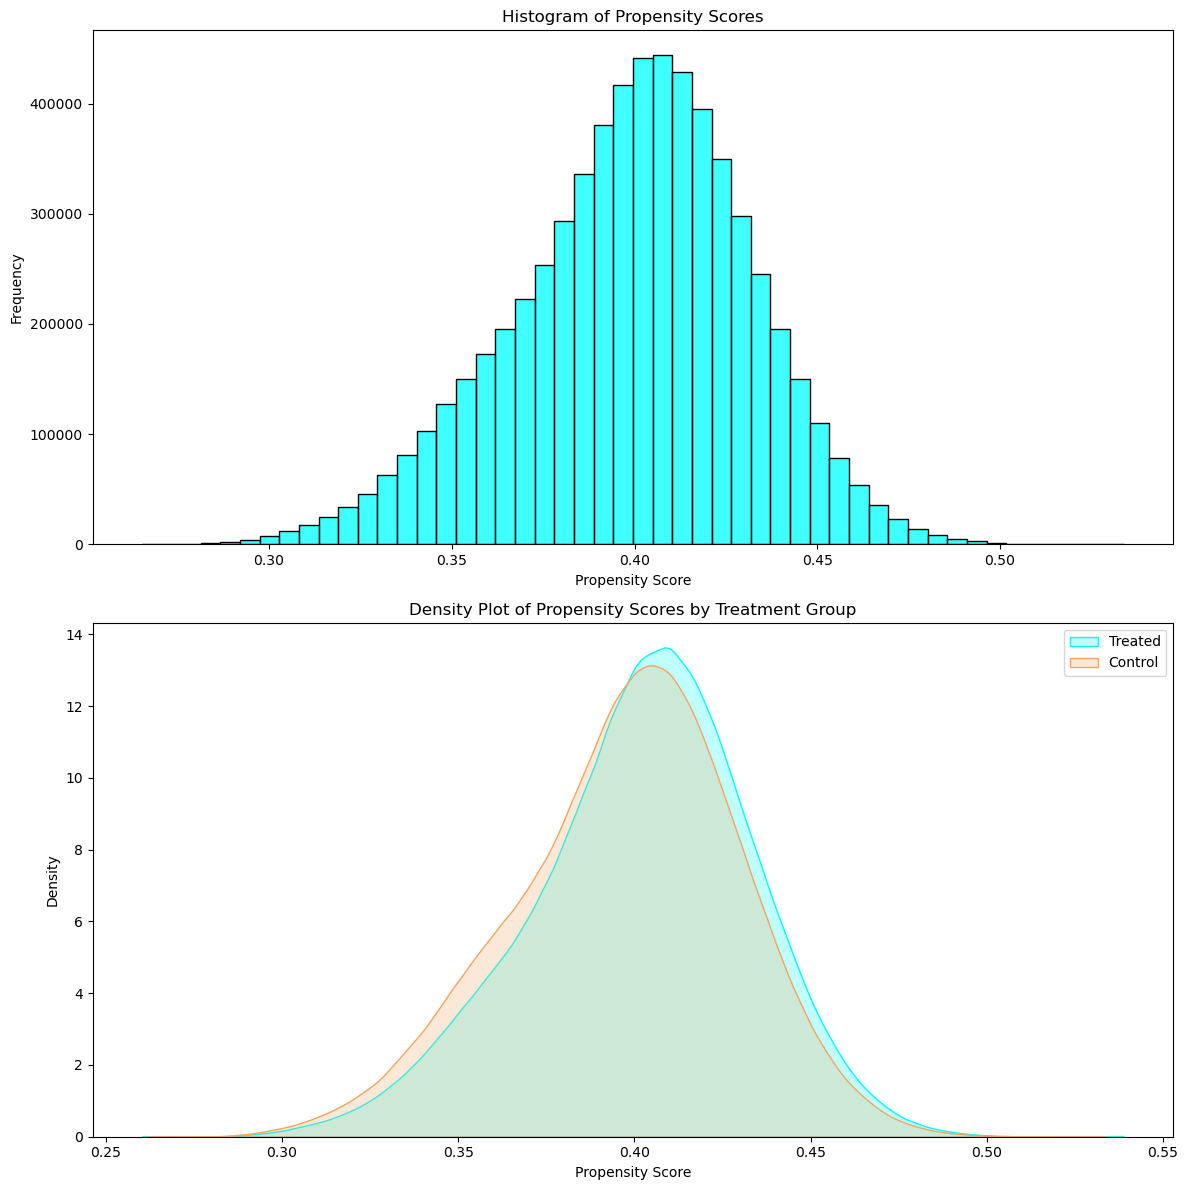

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming merged_data is already available and contains the propensity scores and IPW

# Create a copy of the merged_data
data_copy = merged_data.copy()

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot Histogram of Propensity Scores
sns.histplot(data_copy['propensity_score'], bins=50, kde=False, color='cyan', ax=axs[0])
axs[0].set_title('Histogram of Propensity Scores')
axs[0].set_xlabel('Propensity Score')
axs[0].set_ylabel('Frequency')

# Plot Overlapping Bell Curve (Density Plot) of Propensity Scores by Treatment Group
sns.kdeplot(data_copy[data_copy['Z'] == 1]['propensity_score'], shade=True, color='cyan', label='Treated', ax=axs[1])
sns.kdeplot(data_copy[data_copy['Z'] == 0]['propensity_score'], shade=True, color='sandybrown', label='Control', ax=axs[1])
axs[1].set_title('Density Plot of Propensity Scores by Treatment Group')
axs[1].set_xlabel('Propensity Score')
axs[1].set_ylabel('Density')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
merged_data

,id.practice,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,n.patients,V1_avg,V2_avg,V3_avg,V4_avg,V5_A_avg,V5_B_avg,V5_C_avg,propensity_score,ipw
0,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,113,10.808,2.920,0.540,0.298,0.690,0.274,0.035,0.438360,1.000000
1,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,109,10.768,2.872,0.532,0.274,0.706,0.266,0.028,0.433765,1.000000
2,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,121,10.896,2.868,0.529,0.185,0.727,0.231,0.041,0.421486,1.000000
3,1,0,A,1,A,1,20.774,14.153,0.161,43.432,...,131,10.550,2.718,0.542,0.120,0.702,0.260,0.038,0.416848,1.000000
4,2,0,A,0,C,0,33.566,3.285,0.557,12.722,...,264,11.981,2.947,0.530,-0.116,0.716,0.159,0.125,0.356526,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6799995,499,0,A,0,C,0,31.774,4.354,0.639,69.094,...,1532,11.091,2.979,0.580,0.153,0.783,0.170,0.048,0.380733,0.614813
6799996,500,0,C,1,A,1,22.036,10.508,0.444,13.685,...,238,12.243,2.895,0.466,-0.367,0.769,0.130,0.101,0.362230,1.000000
6799997,500,0,C,1,A,1,22.036,10.508,0.444,13.685,...,221,12.118,2.860,0.471,-0.307,0.769,0.131,0.100,0.367668,1.000000
6799998,500,0,C,1,A,1,22.036,10.508,0.444,13.685,...,247,12.291,2.984,0.478,-0.254,0.785,0.130,0.085,0.373246,1.000000


#### Remarks


### Step 5: Subgroup Analysis for Treatment Effect Heterogeneity 

- What is this code about: Investigating the heterogeneity in treatment effects across different strata defined by categorical and continuous covariates 
- Why is this important in our overall analysis: To understand how the intervention's impact varies among different subgroups within the study population
- What is the expected result: Visual identification of any paradoxes indicating potential confounding in the data.

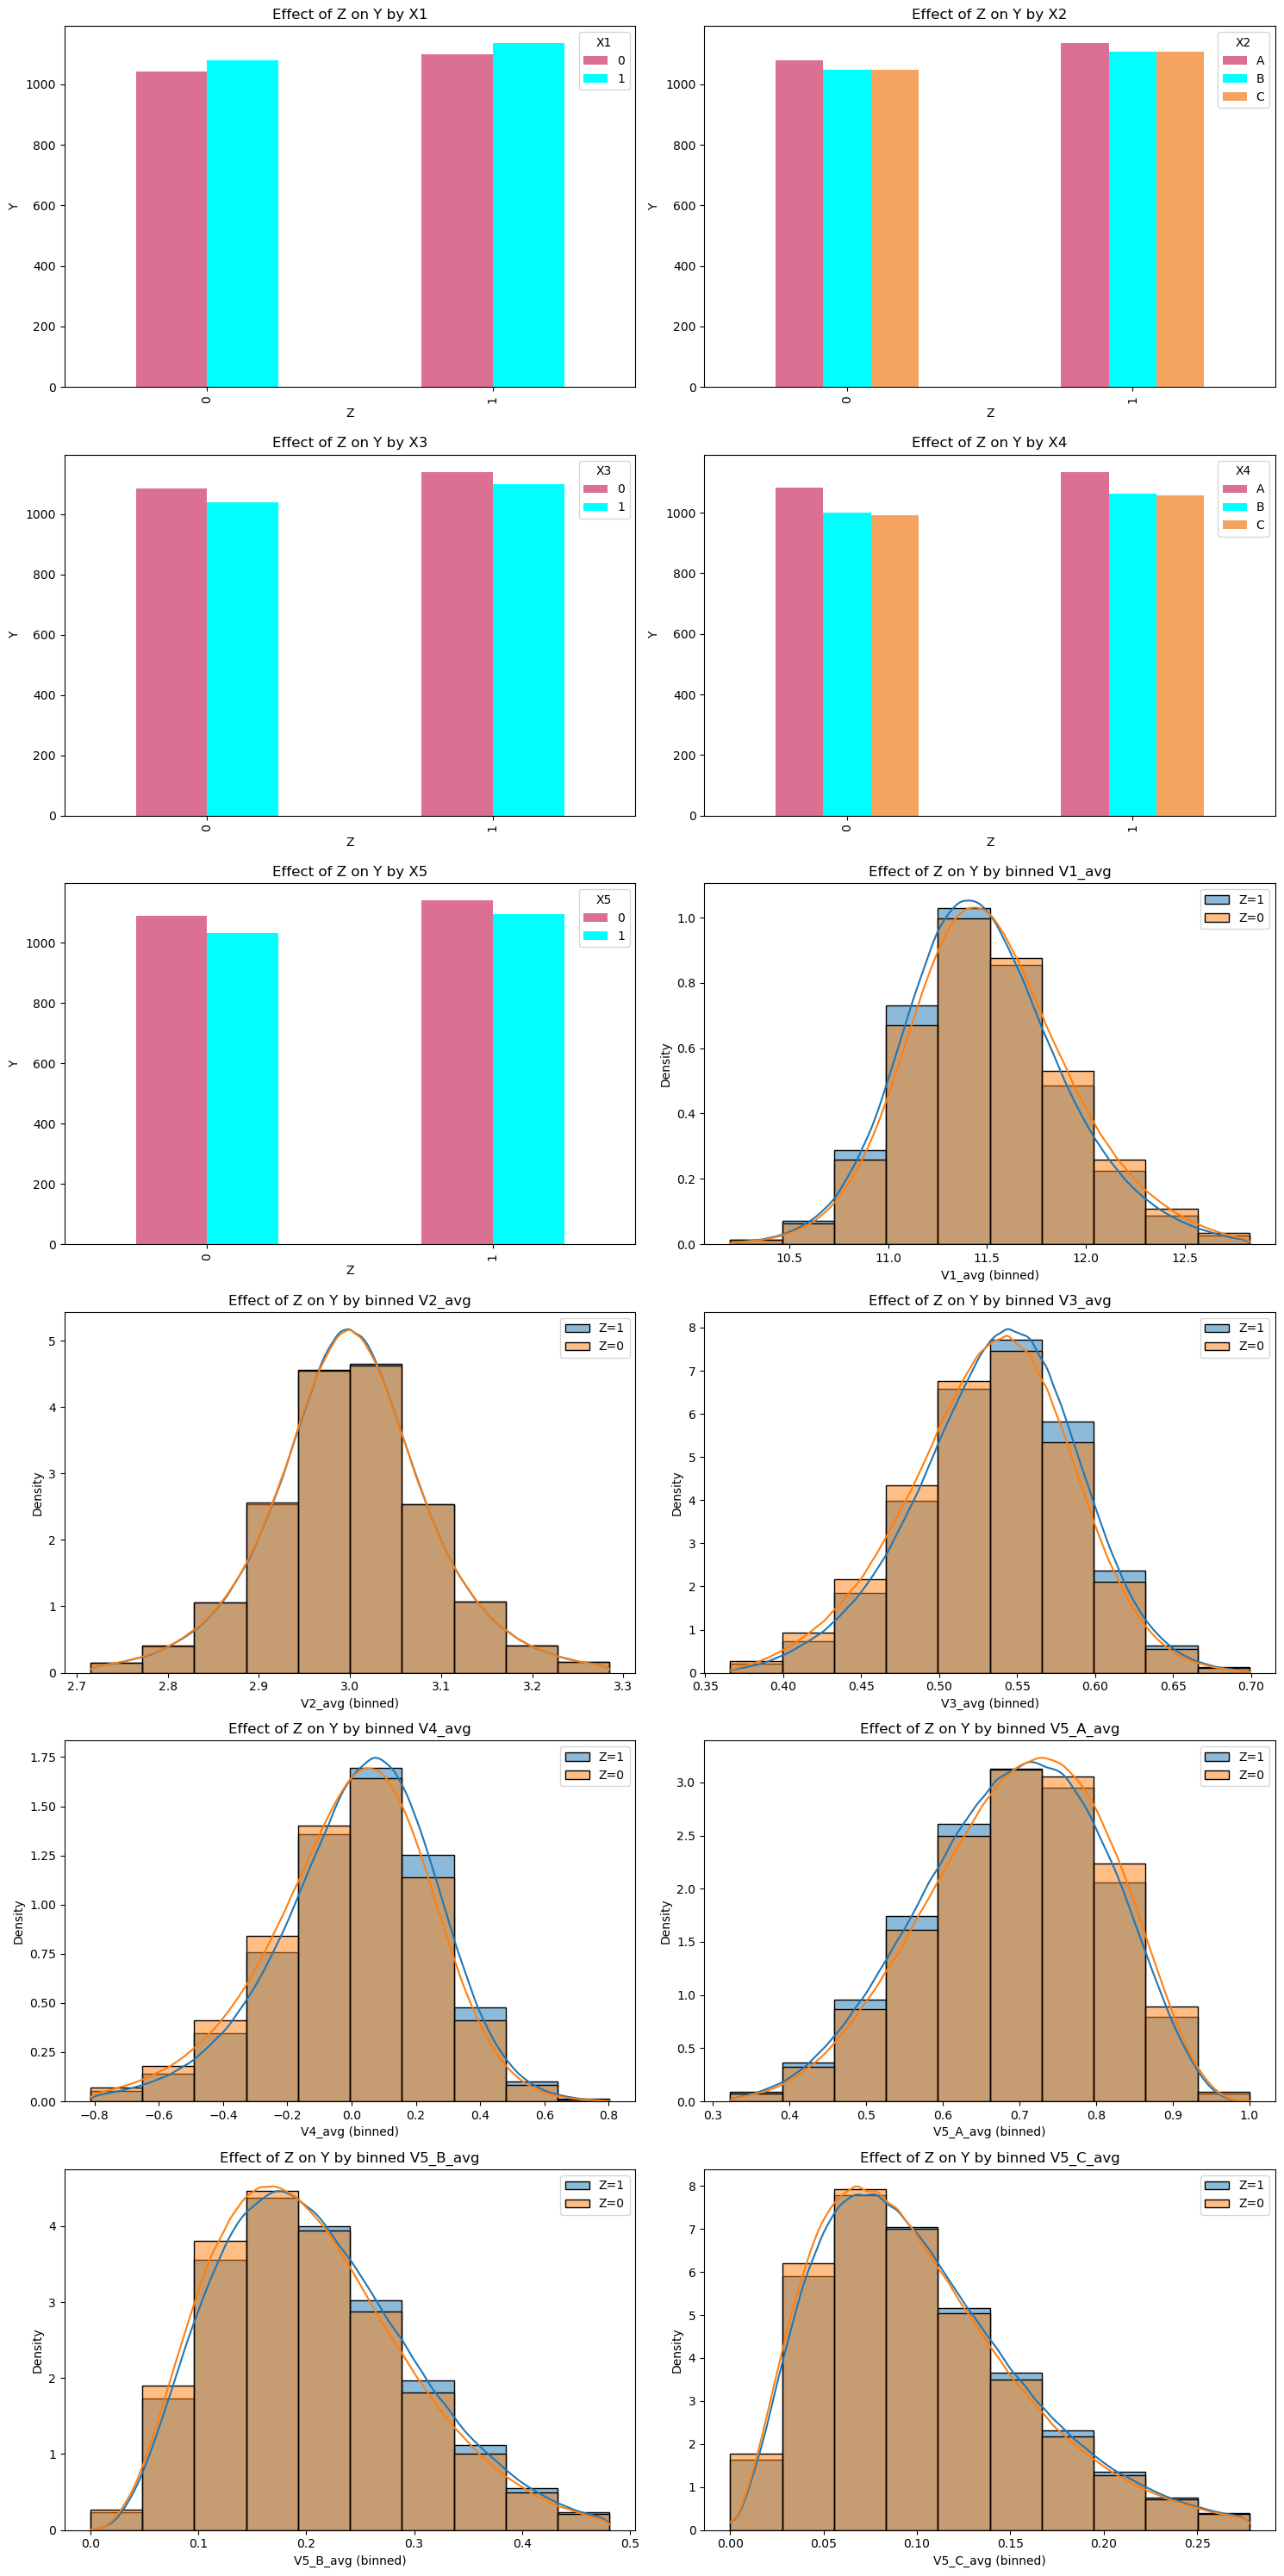

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_simpsons_paradox(data, treatment, outcome, categorical_covariates, continuous_covariates, bins=10):
    data_copy = data.copy()  # Work on a copy of the data to preserve the original DataFrame
    
    # Set up the plot grid
    num_categorical = len(categorical_covariates)
    num_continuous = len(continuous_covariates)
    total_plots = num_categorical + num_continuous
    fig, axes = plt.subplots(nrows=(total_plots // 2) + (total_plots % 2), ncols=2, figsize=(15, 5 * ((total_plots // 2) + (total_plots % 2))))
    
    # Colors
    categorical_colors = ['palevioletred', 'cyan', 'sandybrown']  # Adjust as needed
    
    # Plot categorical covariates
    for i, covariate in enumerate(categorical_covariates):
        ax = axes[i // 2, i % 2]
        grouped_effect = data_copy.groupby([treatment, covariate])[outcome].mean().unstack()
        
        grouped_effect.plot(kind='bar', stacked=False,color=categorical_colors[:len(grouped_effect.columns)], ax=ax)
        ax.set_title(f'Effect of {treatment} on {outcome} by {covariate}')
        ax.set_ylabel(outcome)
        ax.legend(title=covariate)

    # Plot continuous covariates
    for i, covariate in enumerate(continuous_covariates):
        ax = axes[(num_categorical + i) // 2, (num_categorical + i) % 2]
        data_copy[f'{covariate}_binned'] = pd.cut(data_copy[covariate], bins=bins)
        
        for treatment_value in data_copy[treatment].unique():
            sns.histplot(data=data_copy[data_copy[treatment] == treatment_value], x=covariate, bins=bins, kde=True, label=f'{treatment}={treatment_value}', stat='density', ax=ax)
        
        ax.set_title(f'Effect of {treatment} on {outcome} by binned {covariate}')
        ax.set_xlabel(f'{covariate} (binned)')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Lists of covariates
categorical_covariates = ['X1', 'X2', 'X3', 'X4', 'X5']
continuous_covariates = ['V1_avg', 'V2_avg', 'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg']

# Check for Simpson's Paradox in the merged data
check_simpsons_paradox(merged_data, 'Z', 'Y', categorical_covariates, continuous_covariates)
